# Stress Test Surface Analysis

This notebook loads stress test runs produced by `inference/stress_inference.py`, extracts run metadata (model, variant, GPU, etc.), and builds pivot tables plus 3D surface plots for tokens-per-second throughput and peak memory usage. Adjust the configuration cells below to point at specific runs or compare multiple runs.

In [16]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.tri import LinearTriInterpolator, Triangulation
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8-darkgrid')

In [17]:
def detect_reports_root() -> Path:
    '''Best-effort search for the repo reports directory, regardless of notebook cwd.'''
    candidates = []
    cwd = Path.cwd().resolve()
    candidates.append(cwd)
    candidates.append(cwd / 'reports')
    if cwd.parent != cwd:
        candidates.append(cwd.parent)
        candidates.append(cwd.parent / 'reports')
    if len(cwd.parents) > 1:
        candidates.append(cwd.parents[1])
        candidates.append(cwd.parents[1] / 'reports')
    for candidate in candidates:
        if candidate is None:
            continue
        candidate = candidate.resolve()
        reports_dir = candidate if candidate.name == 'reports' else candidate / 'reports'
        if (reports_dir / 'stress').exists():
            return reports_dir
    raise FileNotFoundError('Could not locate reports/stress directory from current working directory.')

REPORTS_ROOT = detect_reports_root()
STRESS_ROOT = REPORTS_ROOT / 'stress'
print(f'Using reports root: {REPORTS_ROOT}')
print(f'Looking for runs under : {STRESS_ROOT}')

Using reports root: /workspace/Attention-From-Scratch/reports
Looking for runs under : /workspace/Attention-From-Scratch/reports/stress


In [18]:
def iter_run_directories(root: Path) -> List[Path]:
    return sorted({path.parent for path in root.rglob('results.jsonl')})

def load_run_records(run_dir: Path) -> List[Dict[str, Any]]:
    metadata_path = run_dir / 'metadata.json'
    results_path = run_dir / 'results.jsonl'
    if not results_path.exists():
        return []
    metadata: Dict[str, Any] = {}
    if metadata_path.exists():
        metadata = json.loads(metadata_path.read_text())
    rows: List[Dict[str, Any]] = []
    with results_path.open() as handle:
        for line in handle:
            line = line.strip()
            if not line or line.startswith('Total output lines'):
                continue
            record = json.loads(line)
            result = record.get('result', {})
            generation = result.get('generation', {})
            runtime = result.get('runtime', {})
            model_info = result.get('model', {})
            gpu_info = runtime.get('gpu', {}) or {}
            input_tokens = generation.get('input_length_tokens', record.get('target_input_tokens'))
            new_tokens = generation.get('new_tokens')
            if new_tokens is None and generation.get('output_length_tokens') is not None and input_tokens is not None:
                new_tokens = generation['output_length_tokens'] - input_tokens
            output_tokens = new_tokens if new_tokens is not None else record.get('target_output_tokens')
            tokens_per_second = generation.get('tokens_per_second')
            max_memory_mb = runtime.get('max_memory_megabytes')
            if max_memory_mb is None and runtime.get('max_memory_bytes') is not None:
                max_memory_mb = runtime['max_memory_bytes'] / (1024 ** 2)
            rows.append({
                'run_directory': str(run_dir),
                'timestamp': result.get('timestamp'),
                'model_name': metadata.get('model_name') or model_info.get('name'),
                'model_variant': metadata.get('model_variant') or model_info.get('variant'),
                'gpu_name': metadata.get('gpu_name') or gpu_info.get('name'),
                'target_input_tokens': record.get('target_input_tokens'),
                'target_output_tokens': record.get('target_output_tokens'),
                'input_tokens': input_tokens,
                'output_tokens': output_tokens,
                'tokens_per_second': tokens_per_second,
                'max_memory_mb': max_memory_mb,
                'device': runtime.get('resolved_device'),
                'dtype': runtime.get('dtype'),
                'temperature': generation.get('temperature'),
                'do_sample': generation.get('do_sample'),
            })
    return rows

def load_all_runs(stress_root: Path) -> pd.DataFrame:
    records: List[Dict[str, Any]] = []
    for run_dir in iter_run_directories(stress_root):
        records.extend(load_run_records(run_dir))
    if not records:
        return pd.DataFrame()
    df = pd.DataFrame(records)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

df = load_all_runs(STRESS_ROOT)
print(f"Loaded {len(df)} rows from {df['run_directory'].nunique() if not df.empty else 0} runs.")
df.head()

Loaded 80 rows from 1 runs.


,run_directory,timestamp,model_name,model_variant,gpu_name,target_input_tokens,target_output_tokens,input_tokens,output_tokens,tokens_per_second,max_memory_mb,device,dtype,temperature,do_sample
0,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:47:44.017460+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,8,8,8,9.4449,26188.6245,cuda,torch.bfloat16,0.8,True
1,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:47:53.776952+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,16,8,16,14.5106,26194.8745,cuda,torch.bfloat16,0.8,True
2,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:48:04.404610+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,32,8,32,20.9963,26207.3745,cuda,torch.bfloat16,0.8,True
3,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:48:15.389764+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,64,8,64,26.5371,26232.3760,cuda,torch.bfloat16,0.8,True
4,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:48:27.213307+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,128,8,93,28.8984,26255.0322,cuda,torch.bfloat16,0.8,True


In [19]:
if df.empty:
    raise RuntimeError('No stress test results found. Run inference/stress_inference.py first.')

run_dirs = sorted(df['run_directory'].unique())
run_dirs

['/workspace/Attention-From-Scratch/reports/stress/olmo2/allenai_OLMo-2-1124-13B-Instruct/NVIDIA_GeForce_RTX_5090/20251109T054735Z']

In [20]:
# Select a single run (latest by default). Override TARGET_RUN to inspect another directory.
latest_run = df.sort_values('timestamp')['run_directory'].iloc[-1]
TARGET_RUN = latest_run
print(f'Using run: {TARGET_RUN}')
run_df = df[df['run_directory'] == TARGET_RUN].copy()
run_df.sort_values(['input_tokens', 'output_tokens']).head()

Using run: /workspace/Attention-From-Scratch/reports/stress/olmo2/allenai_OLMo-2-1124-13B-Instruct/NVIDIA_GeForce_RTX_5090/20251109T054735Z


,run_directory,timestamp,model_name,model_variant,gpu_name,target_input_tokens,target_output_tokens,input_tokens,output_tokens,tokens_per_second,max_memory_mb,device,dtype,temperature,do_sample
0,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:47:44.017460+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,8,8,8,9.4449,26188.6245,cuda,torch.bfloat16,0.8,True
1,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:47:53.776952+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,16,8,16,14.5106,26194.8745,cuda,torch.bfloat16,0.8,True
2,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:48:04.404610+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,32,8,32,20.9963,26207.3745,cuda,torch.bfloat16,0.8,True
3,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:48:15.389764+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,64,8,64,26.5371,26232.3760,cuda,torch.bfloat16,0.8,True
4,/workspace/Attention-From-Scratch/reports/stre...,2025-11-09 05:48:27.213307+00:00,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,8,128,8,93,28.8984,26255.0322,cuda,torch.bfloat16,0.8,True


In [21]:
meta = run_df[['model_name', 'model_variant', 'gpu_name', 'device', 'dtype']].drop_duplicates()
print('Run metadata:')
display(meta)

Run metadata:


,model_name,model_variant,gpu_name,device,dtype
0,olmo2,allenai/OLMo-2-1124-13B-Instruct,NVIDIA GeForce RTX 5090,cuda,torch.bfloat16


In [22]:
tokens_table = run_df.pivot_table(
    index='output_tokens',
    columns='input_tokens',
    values='tokens_per_second',
    aggfunc='mean'
).sort_index().sort_index(axis=1)

memory_table = run_df.pivot_table(
    index='output_tokens',
    columns='input_tokens',
    values='max_memory_mb',
    aggfunc='max'
).sort_index().sort_index(axis=1)

print('Tokens/sec surface table:')
display(tokens_table)
print('Peak memory (MB) surface table:')
display(memory_table)

Tokens/sec surface table:


input_tokens,8,16,32,64,128,256,512,1024,2048
output_tokens,,,,,,,,,
3,NaN,NaN,NaN,4.0064,NaN,NaN,NaN,NaN,2.7044
8,9.4449,8.4145,8.2407,8.7429,8.4283,9.4076,8.6601,7.6509,6.6684
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7922,NaN
16,14.5106,13.7426,15.1764,13.8883,14.0663,14.3598,13.5425,NaN,11.2673
20,NaN,NaN,NaN,15.8647,NaN,NaN,NaN,NaN,NaN
32,20.9963,20.1574,19.9027,NaN,20.1227,20.8023,19.9232,18.1608,17.0223
52,NaN,NaN,NaN,NaN,NaN,NaN,24.6899,NaN,NaN
60,NaN,NaN,25.2587,NaN,NaN,NaN,NaN,NaN,NaN
64,26.5371,25.2649,25.3604,NaN,25.5053,25.5577,24.6765,24.6885,22.4360


Peak memory (MB) surface table:


input_tokens,8,16,32,64,128,256,512,1024,2048
output_tokens,,,,,,,,,
3,NaN,NaN,NaN,26231.7017,NaN,NaN,NaN,NaN,27998.7773
8,26188.6245,26194.8745,26207.3745,26232.3760,26289.3291,26402.7090,26631.2188,27089.7383,27998.7773
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27089.7383,NaN
16,26194.8745,26201.1245,26213.6245,26238.6260,26291.7739,26402.7090,26631.2188,NaN,27998.7773
20,NaN,NaN,NaN,26241.7510,NaN,NaN,NaN,NaN,NaN
32,26207.3745,26213.6245,26226.1245,NaN,26301.8032,26407.8325,26631.2188,27089.7383,27998.7773
52,NaN,NaN,NaN,NaN,NaN,NaN,26631.2188,NaN,NaN
60,NaN,NaN,26248.0010,NaN,NaN,NaN,NaN,NaN,NaN
64,26232.3760,26238.6260,26251.1260,NaN,26327.2817,26428.4478,26631.2188,27089.7383,27998.7773


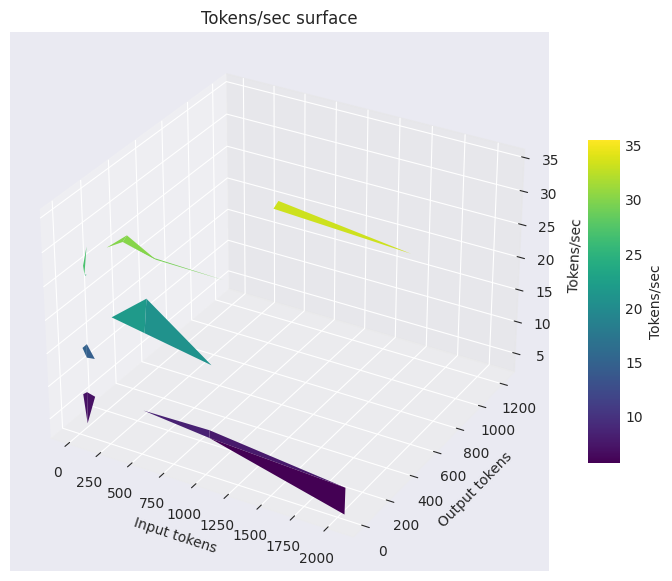

In [23]:
def plot_surface(table: pd.DataFrame, title: str, z_label: str, cmap=cm.viridis) -> None:
    if table.empty:
        raise ValueError('Surface table is empty.')
    x = table.columns.to_numpy()
    y = table.index.to_numpy()
    X, Y = np.meshgrid(x, y)
    Z = table.to_numpy(dtype=float)
    Z_masked = np.ma.array(Z, mask=np.isnan(Z))

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z_masked, cmap=cmap, edgecolor='none')
    ax.set_xlabel('Input tokens')
    ax.set_ylabel('Output tokens')
    ax.set_zlabel(z_label)
    ax.set_title(title)
    fig.colorbar(surf, shrink=0.6, aspect=10, label=z_label)
    plt.show()

plot_surface(tokens_table, 'Tokens/sec surface', 'Tokens/sec', cmap=cm.viridis)

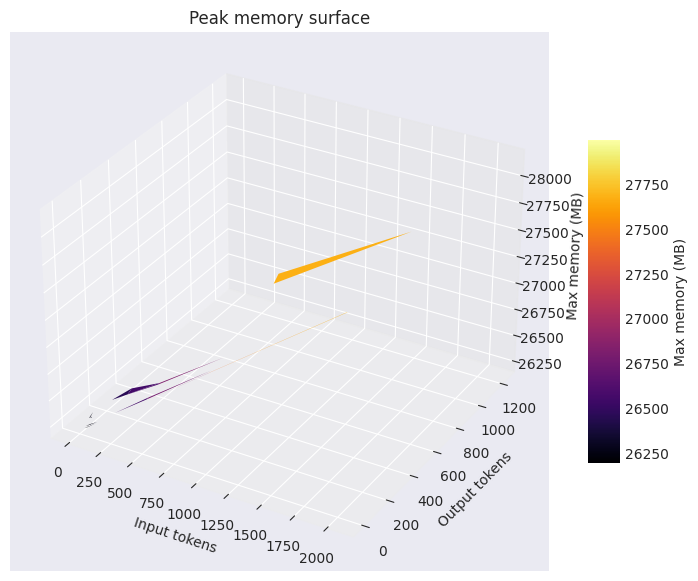

In [24]:
plot_surface(memory_table, 'Peak memory surface', 'Max memory (MB)', cmap=cm.inferno)

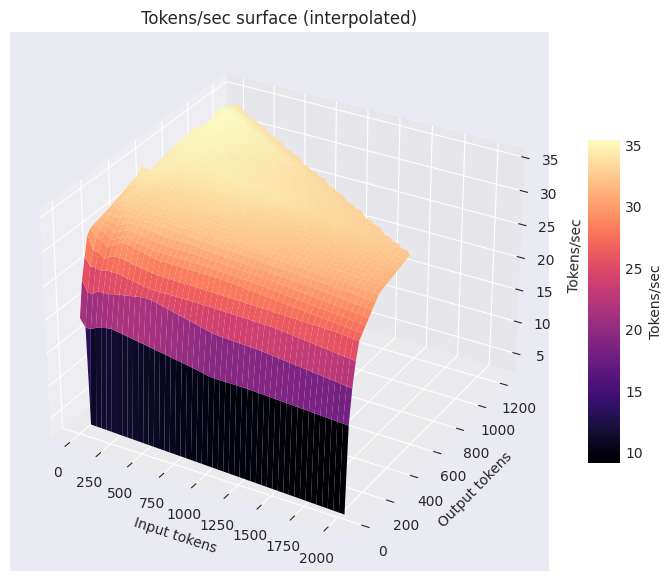

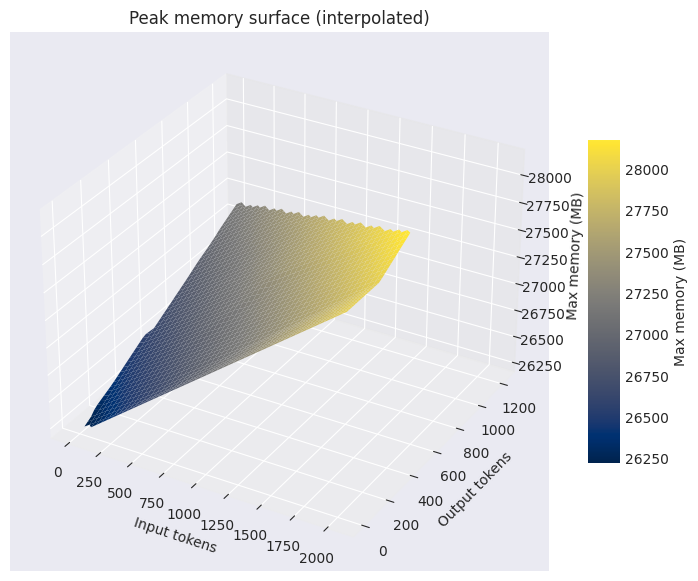

In [25]:
ENABLE_INTERPOLATION = True
GRID_POINTS = 50

def interpolate_surface(run_frame: pd.DataFrame, value_column: str, grid_points: int = GRID_POINTS):
    data = run_frame[['input_tokens', 'output_tokens', value_column]].dropna()
    if data.shape[0] < 3:
        raise ValueError('Need at least 3 data points to interpolate a surface.')
    points = data[['input_tokens', 'output_tokens']].to_numpy(dtype=float)
    values = data[value_column].to_numpy(dtype=float)
    tri = Triangulation(points[:, 0], points[:, 1])
    interpolator = LinearTriInterpolator(tri, values)
    x_grid = np.linspace(points[:, 0].min(), points[:, 0].max(), grid_points)
    y_grid = np.linspace(points[:, 1].min(), points[:, 1].max(), grid_points)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = interpolator(X, Y)
    return X, Y, Z

def plot_interpolated_surface(run_frame: pd.DataFrame, value_column: str, title: str, z_label: str, cmap=cm.plasma, grid_points: int = GRID_POINTS):
    X, Y, Z = interpolate_surface(run_frame, value_column, grid_points)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, edgecolor='none')
    ax.set_xlabel('Input tokens')
    ax.set_ylabel('Output tokens')
    ax.set_zlabel(z_label)
    ax.set_title(f"{title} (interpolated)")
    fig.colorbar(surf, shrink=0.6, aspect=10, label=z_label)
    plt.show()

if ENABLE_INTERPOLATION:
    plot_interpolated_surface(run_df, 'tokens_per_second', 'Tokens/sec surface', 'Tokens/sec', cmap=cm.magma)
    plot_interpolated_surface(run_df, 'max_memory_mb', 'Peak memory surface', 'Max memory (MB)', cmap=cm.cividis)
else:
    print('Interpolation disabled; set ENABLE_INTERPOLATION = True to show smoothed surfaces.')
